In [1]:
library(tidyverse)
library(brms)
library(here)
library(grid)
library(gridExtra)
library(lemon)
theme_set(theme_bw())
helpers_path = paste0(here(),'/analysis/helpers/')
inputs_path = paste0(here(),'/inputs/')
source(paste0(helpers_path, '01_clean_behavioral_data.R'))
fig_out_path = paste0(here(), '/outputs/fig/')
rm(data_bc_clean)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Rcpp

Loading 'brms' package (version 2.19.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:stats':

    ar


here() starts at /Users/zenkavi/Documents/RangelLab/NovelVsRepeated/behavior


Attaching package: 'gridExtra'


The following object is masked from 'package:dply

[1] "Done loading data."
[1] "Resetting helpers path..."


# Wrangling

In [2]:
data_yn_clean = data_yn_clean %>%
  mutate(correct = ifelse(possiblePayoff>reference & yesChosen == 1, 1, ifelse(possiblePayoff < reference & yesChosen == 0, 1, 0))) %>%
  mutate(type_chr = ifelse(type == 1, "Over Exposure", "Regular Exposure"),
         week = ifelse(week == 1, "Week 1", ifelse(week == 2, "Week 2", ifelse(week == 3, "Week 3", NA))),
         week = factor(week, levels = c("Week 1", "Week 2", "Week 3"))) %>%
  mutate(val_diff = possiblePayoff - reference,
         abs_val_diff = abs(possiblePayoff - reference),
         val_diff_bin = round(val_diff/50),
         val_diff_bin_str = paste0(val_diff_bin*50-25,":",val_diff_bin*50+25),
         val_diff_bin_str = factor(val_diff_bin_str, levels = c("-225:-175", "-175:-125", "-125:-75", "-75:-25", "-25:25", "25:75", "75:125", "125:175", "175:225")),
         time_bin = ifelse(day == 1, "Day 1", ifelse(day == 2, "Day 2", ifelse(day == 3, "Day 3", ifelse((day > 3) & (day < 8), "Week 2", "Week 3"))))) %>%
  mutate(subject = recode(subnum, 
                    `601` = "Subject 1", 
                    `609` = "Subject 2",
                    `611` = "Subject 3",
                    `619` = "Subject 4",
                    `621` = "Subject 5",
                    `629` = "Subject 6"))

# Psychometrics

In [3]:
sub_summary = data_yn_clean %>%
  mutate(time_bin = ifelse(day == 1, "Day 1", ifelse(day == 2, "Day 2", ifelse(day == 3, "Day 3", ifelse((day > 3) & (day < 8), "Week 2", "Week 3")))),
         time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  group_by(subject, time_bin, val_diff_bin_str, val_diff_bin, type_chr) %>%
  summarise(mean_y = mean(yesChosen),
            sem_y = sd(yesChosen)/sqrt(n()),
            .groups="keep") %>%
  mutate(val_diff_bin = val_diff_bin * 50) 

# sub_summary

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


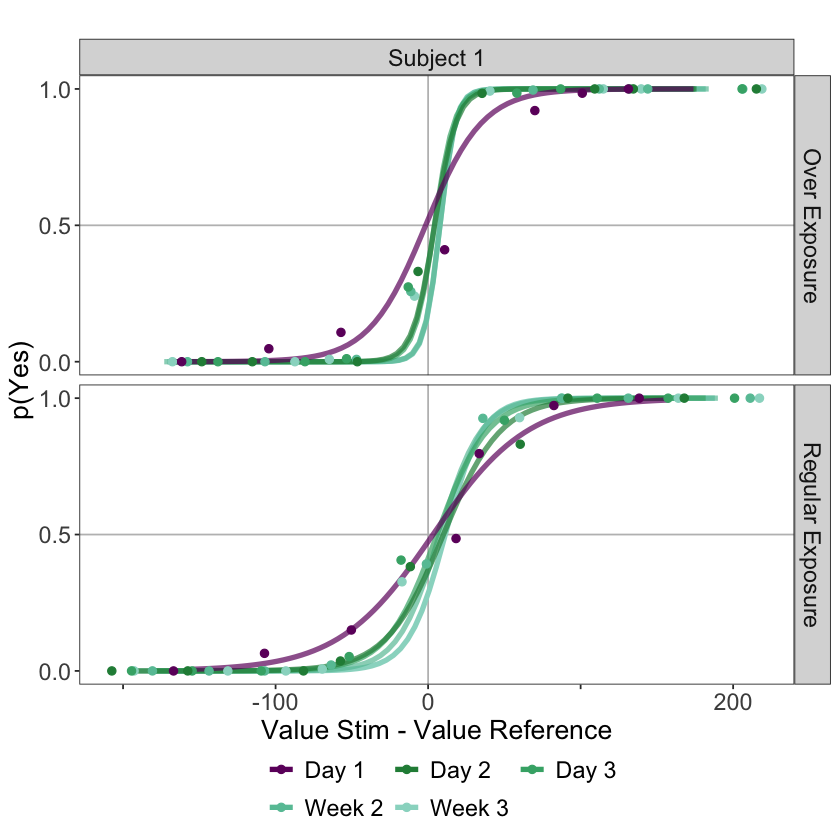

In [4]:
data_yn_clean %>%
  filter(subject == "Subject 1") %>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  ggplot() +
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = time_bin, alpha = time_bin), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, linewidth = 1.5)+
  # geom_point(data = sub_summary %>% filter(subject == "Subject 1"), aes(val_diff_bin, mean_y, color = time_bin), size = 2)+
  geom_jitter(data = sub_summary %>% filter(subject == "Subject 1"), aes(val_diff_bin, mean_y, color = time_bin), size = 2)+
  facet_grid(type_chr ~ subject)+
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
      #   legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  guides(color = guide_legend(nrow = 2, byrow = T)) +
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76", "#66c2a4", "#99d8c9"),
                     breaks = c("Day 1", "Day 2", "Day 3", "Week 2", "Week 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))+
  guides(alpha = "none")

  # ggsave(file=paste0(fig_out_path, 'ccn_yn_Singlesubj_pYesOverValDiffAcrossTime.png'), height = 5.5, width = 4.5, units="in")

# RT

In [6]:
data_yn_clean = data_yn_clean %>%
  mutate(abs_val_diff_bin_str =  paste0(abs(val_diff_bin)*50-25,":",abs(val_diff_bin)*50+25),
         abs_val_diff_bin_str = ifelse(abs_val_diff_bin_str ==  "-25:25", "0:25", abs_val_diff_bin_str),
         abs_val_diff_bin_str = factor(abs_val_diff_bin_str, levels = c("0:25", "25:75", "75:125", "125:175", "175:225", "225:275")))

In [7]:
sub_summary = data_yn_clean %>%
  group_by(subject, time_bin, abs_val_diff_bin_str, type_chr) %>%
  summarise(mean_y = mean(log(rt)),
            .groups="keep") %>%
  mutate(mean_rt = exp(mean_y), 
         abs_val_diff = (as.numeric(abs_val_diff_bin_str) - 1) * 50)

# sub_summary

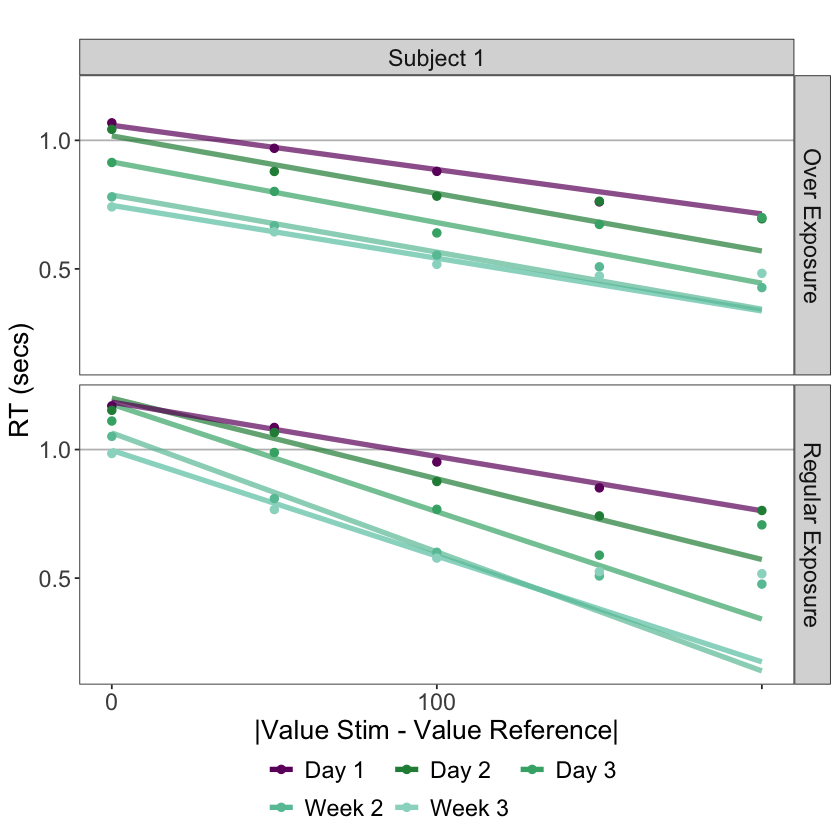

In [8]:
data_yn_clean %>%
  filter(subject == "Subject 1") %>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  ggplot() +
  geom_hline(aes(yintercept = 1), color = "gray") +
  geom_line(aes(abs_val_diff, rt, color = time_bin, alpha = time_bin), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = TRUE)+
  geom_point(data = sub_summary %>% filter(subject == "Subject 1"), aes(abs_val_diff, mean_rt, color = time_bin), size = 2)+
  facet_grid(type_chr ~ subject)+
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        # legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  guides(color = guide_legend(nrow = 2, byrow = T)) +
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76", "#66c2a4", "#99d8c9"),
                     breaks = c("Day 1", "Day 2", "Day 3", "Week 2", "Week 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))+
  guides(alpha = "none")

# ggsave(file=paste0(fig_out_path, 'ccn_yn_Singlesubj_RTOverValDiffAcrossTime.jpg'), height = 5.5, width = 4.5, units="in")

# RLDDM

What is the interesting question here? "Are you learning about the HT in an isolated manner? Or is what you have learned about them leaking to other stims in some way?"  

This is a bit of a straw man argument. If there was no generalization there would be no reason for behavior in RE to improve. So there is learning for more than just the stim value but what is the representation that is being updated?

## Feed values from previous and change learning rates

In [99]:
source(paste0(helpers_path, "rlddm/yn_rlddm.R"))

In [136]:
cur_subnum = 601
init_attr_values = list(val_shape = rep(0, 6), val_orientation = rep(0, 11), val_filling = rep(0, 9))
init_ht_values = list()
  
stims = data_yn_clean %>% filter(subnum == cur_subnum & day %in% c(1))
sim_data_d1 = sim_task(stims, init_ht_values, init_attr_values, d = .0004, sigma = .005, alpha = .03, theta = 0.03, oe_noise = 5, re_noise = 30, nonDecisionTime = 300, barrierDecay = 0.01)
sim_data_d1$out$day = 1

stims = data_yn_clean %>% filter(subnum == cur_subnum & day %in% c(2))
sim_data_d2 = sim_task(stims, sim_data_d1$values$ht_vals, sim_data_d1$values, d = .0004, sigma = .005, alpha = 0.01, theta = 0.02, oe_noise = 5, re_noise = 10, nonDecisionTime = 300, barrierDecay = .01)
sim_data_d2$out$day = 2

stims = data_yn_clean %>% filter(subnum == cur_subnum & day %in% c(3))
sim_data_d3 = sim_task(stims, sim_data_d2$values$ht_vals, sim_data_d2$values, d = .0004, sigma = .005, alpha = 0.01, theta = 0.02, oe_noise = 5, re_noise = 5, nonDecisionTime = 300, barrierDecay = .01)
sim_data_d3$out$day = 3


In [137]:
sim_data = rbind(sim_data_d1$out, sim_data_d2$out, sim_data_d3$out) %>%
  # filter(type == 1) %>%
  mutate(type_chr = ifelse(type == 1, "Over Exposure", "Regular Exposure"),
         val_diff = possiblePayoff - reference,
         abs_val_diff = abs(possiblePayoff - reference),
         val_diff_bin = round(val_diff/50),
         val_diff_bin_str = paste0(val_diff_bin*50-25,":",val_diff_bin*50+25),
         val_diff_bin_str = factor(val_diff_bin_str, levels = c("-225:-175", "-175:-125", "-125:-75", "-75:-25", "-25:25", "25:75", "75:125", "125:175", "175:225")),
         yesChosen = ifelse(choice == "yes", 1, 0)) %>%
    mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 1", "Day 2", "Day 3")))


In [138]:
with(sim_data, table(day, tooSlow))

       tooSlow
day       0   1
  Day 1 789  11
  Day 2 790  10
  Day 3 784  16

In [139]:
with(sim_data, table(day, tooFast))

       tooFast
day       0
  Day 1 800
  Day 2 800
  Day 3 800

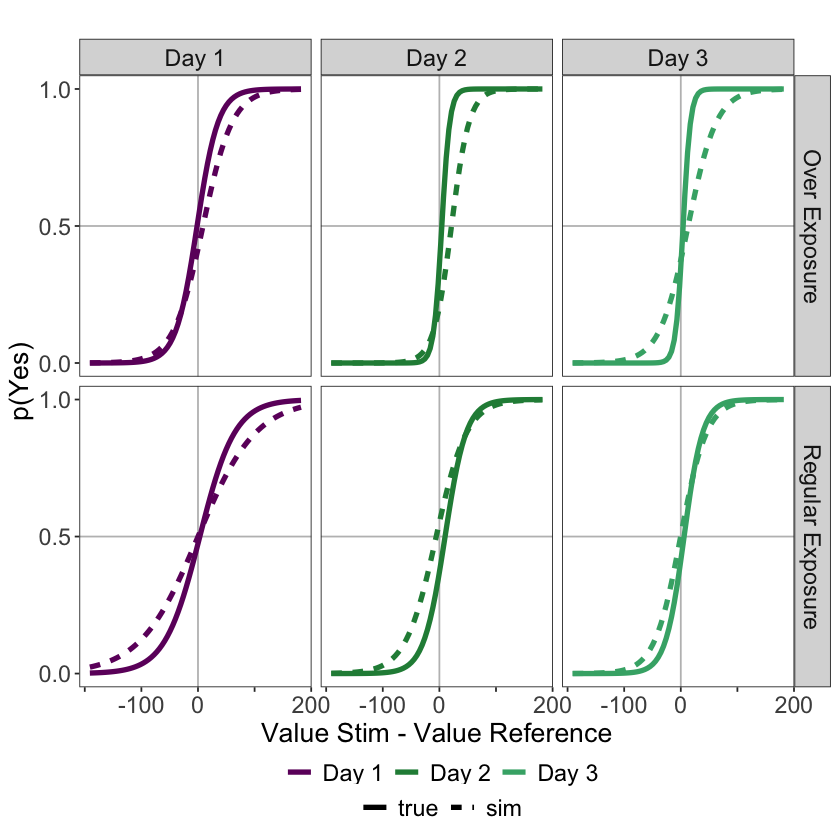

In [140]:
sim_data %>%
  select(val_diff, yesChosen, type_chr, day) %>%
  mutate(data_type = "sim") %>%
  rbind(data_yn_clean %>%
          filter((subnum == cur_subnum) & (day %in% c(1, 2, 3))) %>%
          select(val_diff, yesChosen, type_chr, day) %>%
          mutate(data_type = "true",
                 day = paste0("Day ", day),
                 day = factor(day, levels = c("Day 1", "Day 2", "Day 3")))) %>%
  mutate(data_type = factor(data_type, levels = c("true", "sim"))) %>%
  ggplot() +
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = day, linetype = data_type), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = T) +
  facet_grid(type_chr ~ day) +
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "", linetype = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76"),
                     breaks = c("Day 1", "Day 2", "Day 3"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

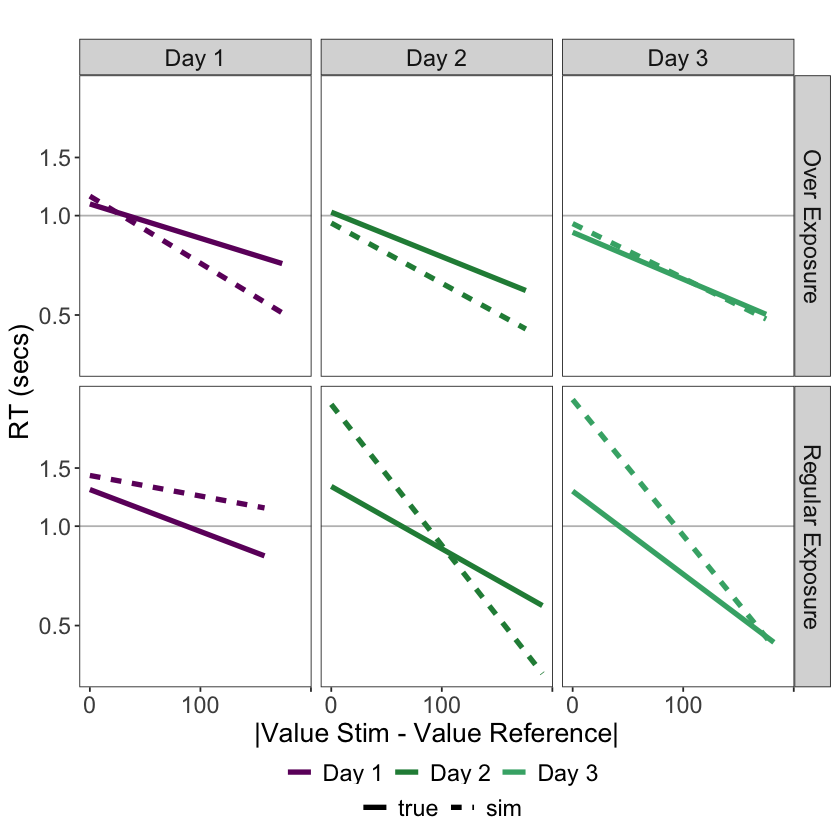

In [141]:
sim_data %>%
  mutate(rt = reactionTime) %>%
  select(abs_val_diff, rt, type_chr, day) %>%
  mutate(data_type = "sim") %>%
  rbind(data_yn_clean %>%
          filter((subnum == cur_subnum) & (day %in% c(1, 2, 3))) %>%
          select(abs_val_diff, rt, type_chr, day) %>%
          mutate(data_type = "true",
                 day = paste0("Day ", day),
                 day = factor(day, levels = c("Day 1", "Day 2", "Day 3")))) %>%
  mutate(data_type = factor(data_type, levels = c("true", "sim"))) %>%
  ggplot() +
  geom_hline(aes(yintercept = 1), color = "gray") + 
  geom_line(aes(abs_val_diff, rt, color = day, linetype = data_type), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, linewidth = 1.5)+
  facet_grid(type_chr ~ day) +
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "", linetype = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76"),
                     breaks = c("Day 1", "Day 2", "Day 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  # scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5), limits = c(0.001,8))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))